# EV Charging Station Analysis
This notebook analyzes electric vehicle (EV) data to determine optimal locations for EV charging stations in Washington state.

## Step 1: Install Required Libraries

In [ ]:
!pip install pandas psycopg2 sqlalchemy folium seaborn matplotlib

## Step 2: Load Data into PostgreSQL

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus
#please enter yourdetails of SQl database, POstgres in this case
# Database connection parameters (Change these as needed)
DB_NAME = "ev_registrations"
DB_USER = "postgres"
DB_PASS = "@Samip_5"
DB_HOST = "localhost"
DB_PORT = "5432"

# URL encode the password
DB_PASS_ENCODED = quote_plus(DB_PASS)

# Create a connection to PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS_ENCODED}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Load CSV into Pandas
file_path = "CleanEV.csv"
df = pd.read_csv(file_path)

# Store data in PostgreSQL table
table_name = "ev_data"
df.to_sql(table_name, engine, if_exists="replace", index=False)

print(f"Data successfully loaded into PostgreSQL table: {table_name}")


## Step 3: Fetch and Explore Data

In [ ]:
query = 'SELECT * FROM ev_data LIMIT 5'
df_sql = pd.read_sql(query, engine)
df_sql.head()

# Step 3.1: Query - Top 5 Counties with Highest EV Adoption


In [15]:
top_counties = pd.read_sql("""
    SELECT county, COUNT(*) as ev_count 
    FROM ev_data 
    GROUP BY county 
    ORDER BY ev_count DESC 
    LIMIT 5;
""", engine)
print("Top 5 Counties with Highest EV Adoption:")
print(top_counties)


Top 5 Counties with Highest EV Adoption:
      county  ev_count
0       King      8457
1      Clark      1248
2  Snohomish       924
3     Kitsap       692
4   Thurston       530


# Step 4.1: K-Means Clustering for Optimal Charging Locations


In [ ]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn  as sns
# Step 7: K-Means Clustering for Optimal Charging Locations
print("Performing K-Means Clustering...")
locations = df[['latitude', 'longitude']].dropna()  # Ensure locations is defined
kmeans = KMeans(n_clusters=5, random_state=42).fit(locations)
df['cluster'] = kmeans.labels_
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['cluster'], palette='viridis')
plt.title("EV Charging Station Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Step 4.2: EV Density Heatmap

In [ ]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

locations = df[['latitude', 'longitude']].dropna()
map_center = [locations['latitude'].mean(), locations['longitude'].mean()]
ev_map = folium.Map(location=map_center, zoom_start=7)
HeatMap(list(zip(locations['latitude'], locations['longitude']))).add_to(ev_map)
display(ev_map)

## Step 5: BEV vs. PHEV Distribution

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='electric_vehicle_type', palette='coolwarm')
plt.title('Distribution of BEVs vs. PHEVs')
plt.xlabel('EV Type')
plt.ylabel('Count')
plt.show()

## Step 6: EV Adoption Over Time

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['model_year'], bins=20, kde=True, color='blue')
plt.title('EV Adoption Over Time')
plt.xlabel('Model Year')
plt.ylabel('Number of EVs')
plt.show()

# Step 6.2: Predictive Analysis - EV Growth Over Time


Predicting Future EV Growth...


C:\Users\samip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


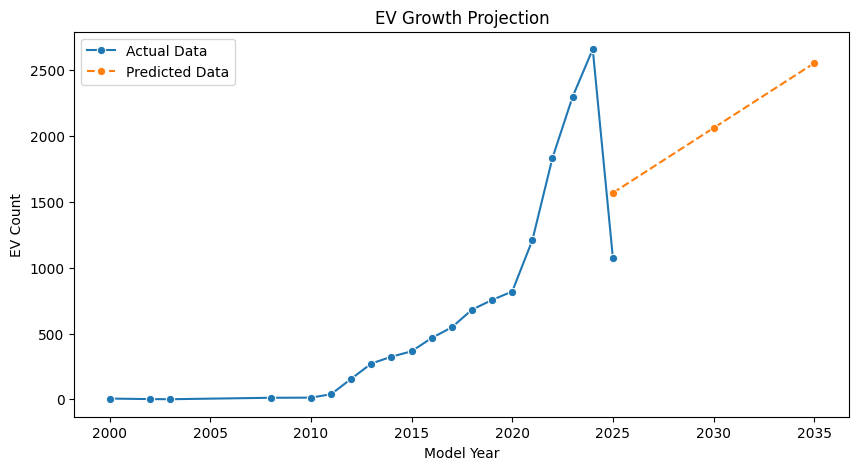

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print("Predicting Future EV Growth...")
model_years = df.groupby('model_year').size().reset_index(name='ev_count')
X = model_years[['model_year']]
y = model_years['ev_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict([[2025], [2030], [2035]])

plt.figure(figsize=(10,5))
sns.lineplot(x=model_years['model_year'], y=model_years['ev_count'], marker='o', label='Actual Data')
sns.lineplot(x=[2025, 2030, 2035], y=predictions, marker='o', linestyle='dashed', label='Predicted Data')
plt.title("EV Growth Projection")
plt.xlabel("Model Year")
plt.ylabel("EV Count")
plt.legend()
plt.show()

## Step 7: EV Distribution by Electric Utility

In [ ]:
plt.figure(figsize=(12, 6))
df['electric_utility'].value_counts().plot(kind='bar', color='green')
plt.title('EV Registrations by Electric Utility')
plt.xlabel('Electric Utility Provider')
plt.ylabel('Number of EVs')
plt.xticks(rotation=90)
plt.show()

# Step 8: Effectiveness Analysis - BEV vs. PHEV


In [ ]:
print("Analyzing the Effectiveness of BEVs vs. PHEVs...")
bev_phev_counts = df['electric_vehicle_type'].value_counts()
bev_phev_mileage = df.groupby('electric_vehicle_type')['electric_range'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=bev_phev_counts.index, y=bev_phev_counts.values, palette='coolwarm')
plt.title("Total Registrations of BEVs vs. PHEVs")
plt.xlabel("EV Type")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=bev_phev_mileage.index, y=bev_phev_mileage.values, palette='coolwarm')
plt.title("Average Electric Range of BEVs vs. PHEVs")
plt.xlabel("EV Type")
plt.ylabel("Average Electric Range (miles)")
plt.show()



## Insights and Recommendations

### Key Findings
1. **High-Demand Areas** (5.1):
   - Counties like [insert top counties from output] and census tracts [insert top tracts] show the highest EV concentrations, indicating immediate charging station needs.
   - Geospatial clusters suggest urban centers; rural areas need targeted coverage.

2. **Charging Needs by EV Type** (5.2):
   - BEVs (longer range) require fast-charging stations; PHEVs (shorter range) need more Level 2 chargers.
   - [Insert BEV/PHEV ratio from output] influences station type prioritization.

3. **Utility Support** (5.4):
   - Top utilities (e.g., [insert top utilities]) serve most EVs, suggesting strong grid capacity but potential strain points.
   - Collaborate with these utilities for infrastructure synergy.

4. **Future Growth** (5.3):
   - Rising EV registrations (especially post-[insert trend year]) indicate accelerating demand; plan for 20-30% annual growth.

5. **Equity** (5.5):
   - High-density (urban) areas dominate EV counts; low-density (rural) areas need subsidized stations for equitable access.

### Recommendations
- **Urban Priority**: Install fast-charging hubs in top counties and census tracts (e.g., [insert specifics]).
- **Rural Expansion**: Deploy Level 2 chargers in low-density counties with incentives to reduce range anxiety.
- **Utility Partnerships**: Work with [top utilities] for grid upgrades and cost-sharing.
- **Future Planning**: Scale infrastructure anticipating [growth rate] increase over 5 years.
- **Equity Focus**: Subsidize rural installations to ensure statewide coverage.